# Sequentially Comparing Forecasters on Synthetic Data

Here, we compare our e-processes against the **Diebold-Mariano (DM)** test of _unconditional_ predictive ability and the **Giacomini-White (GW)** test of _conditional_ predictive ability. 
Both are asymptotic tests with stationarity/mixing assumptions; each also has some modeling assumption (error-based losses for DM; linear conditional models for GW).

We use the package [`epftoolbox`](https://epftoolbox.readthedocs.io/en/latest/) to implement the DM and GW tests. (It requires `tensorflow>=2.2` although we don't use the functionality here.)

See also: Section H.2 in our paper.

YJ Choe [yjchoe@cmu.edu]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os.path

import comparecast as cc

In [2]:
from epftoolbox.evaluation import DM
from epftoolbox.evaluation.gw import gwtest

## Hyperparameter Settings

In [3]:
# which scoring rule to use
scoring_rule = "brier"

# significance level
alpha = 0.05

# whether to use the log scale on x-axis (time)
use_logx = False

# size up label fonts
font_scale = 1.75

## Forecasts on Synthetic Data

We create a case where there reality is non-stationary and also not noisy.

In [4]:
data_name = "sigmoid"
data_file = f"forecasts/{data_name}.csv"
plots_dir = f"plots/dmgw_power/{data_name}"
savefig_dpi = 300

# data = cc.data_utils.synthetic.get_data("default", size=10000, noise=0.0)
# data.to_csv(data_file, index=False)
data = cc.data_utils.synthetic.get_data(data_file, size=10000)
data

,time,y,true_probs,constant_0.5,constant_0,constant_1,laplace,k29_epa,k29_poly3,k29_rbf0.01,mix_01_noiseless,mix_01,mix_10_noiseless,mix_10
0,1,0,0.176406,0.5,0.0,1.0,0.500000,0.000000,0.000000,0.000000,0.2,1.000000,0.8,1.000000
1,2,0,0.049999,0.5,0.0,1.0,0.333333,0.000000,0.000000,0.000000,0.2,0.000000,0.8,0.690548
2,3,0,0.117741,0.5,0.0,1.0,0.250000,0.000000,0.000000,0.000000,0.2,0.000000,0.8,1.000000
3,4,0,0.253642,0.5,0.0,1.0,0.200000,0.000000,0.000000,0.000000,0.2,0.000000,0.8,0.384349
4,5,0,0.225698,0.5,0.0,1.0,0.166667,0.000000,0.000000,0.000000,0.2,0.000000,0.8,0.626115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,1,0.857929,0.5,0.0,1.0,0.273082,0.922852,0.898438,0.945312,0.8,0.834358,0.2,0.000000
9996,9997,1,1.000000,0.5,0.0,1.0,0.273155,0.925781,0.906250,0.945312,0.8,0.144735,0.2,0.637117
9997,9998,1,1.000000,0.5,0.0,1.0,0.273227,0.928711,0.913086,0.945312,0.8,0.632395,0.2,0.000000
9998,9999,1,1.000000,0.5,0.0,1.0,0.273300,0.932617,0.918945,0.945312,0.8,0.000000,0.2,0.000000


In [5]:
# only use k29_poly3
data = data.rename(columns={"k29_poly3": "k29"})

name_p = "k29"
name_q = "laplace"

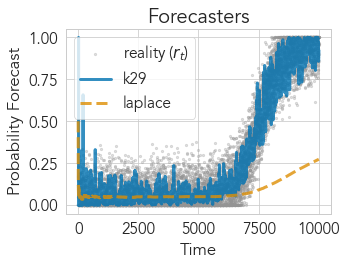

In [6]:
cc.plot_forecasts(
    data, 
    forecasters=[name_p, name_q],
    plots_dir=plots_dir, 
    use_logx=use_logx,
    font_scale=font_scale,
    figsize=(5, 4),
    legend_out=False,
    savefig_dpi=savefig_dpi,
)

## CS for $\Delta_t(\hat{p}_\text{k29-poly3}, \hat{p}_\text{laplace})$

In [7]:
cc.compute_true_deltas(
    data[name_p],
    data[name_q],
    data["true_probs"],
    scoring_rule=scoring_rule
)

array([0.07359446, 0.07568633, 0.05166738, ..., 0.11336776, 0.11340858,
       0.11344947])

In [8]:
results = cc.compare_forecasts(
    data, 
    name_p, 
    name_q, 
    aligned_forecasts=True,
    compute_cs=True,
    lag=1,
    scoring_rule=scoring_rule,
    alpha=alpha,
)
results

,time,lcb,ucb,e_pq,e_qp
0,1,-9.836275,10.336275,1.060372e+00,0.873247
1,2,-4.862582,5.223693,1.094559e+00,0.827561
2,3,-3.220888,3.503295,1.112239e+00,0.801757
3,4,-2.405666,2.637472,1.122837e+00,0.785197
4,5,-1.918977,2.115533,1.129830e+00,0.773679
...,...,...,...,...,...
9995,9996,0.097658,0.121120,1.000000e+07,0.001161
9996,9997,0.097700,0.121161,1.000000e+07,0.001161
9997,9998,0.097741,0.121202,1.000000e+07,0.001161
9998,9999,0.097782,0.121243,1.000000e+07,0.001161


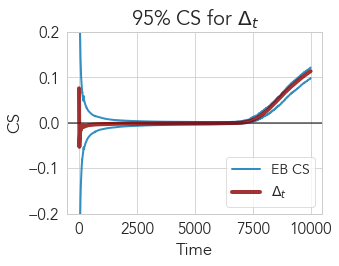

In [9]:
results, axes = cc.plot_comparison(
    data, 
    name_p, 
    name_q, 
    scoring_rule=scoring_rule,    
    plots_dir=None, 
    alpha=alpha,
    baselines=(),
    plot_e=False,
    plot_diagnostics=False,
    plot_width=False,
    use_logx=use_logx,
    ylim_scale=0.2,
    font_scale=font_scale,
    no_title=True,
)
axes[0].set(ylabel="CS")
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "ebcs.pdf"), dpi=savefig_dpi)
None

## DM/GW Tests of (Un)conditional Predictive Ability

These tests are NOT anytime-valid and are asymptotic. They also come with different assumptions which are not often checked in practice (Diebold 2013).

### DM Test

In [10]:
# use squared loss
norm = 2
T = len(data)
mid_T = 4000

# hack to make it 2 columns (second column not meaningful)
y, fc_p, fc_q = [
    np.vstack([data[column].values, 1 - data[column].values]).T
    for column in ["y", name_p, name_q]
]

# direction is in reverse to our null
print(f"DM p-value at T={mid_T}:", DM(y[:mid_T], fc_q[:mid_T], fc_p[:mid_T], norm=norm))
print(f"DM p-value at T={T}:", DM(y, fc_q, fc_p, norm=norm))

DM p-value at T=4000: [0.99644733 0.99644733]
DM p-value at T=10000: [0. 0.]


In [11]:
DM(y, fc_q, fc_p, norm=norm)

array([0., 0.])

In [12]:
cc.compute_cfdr(DM(y, fc_q, fc_p, norm=norm))

array([ True,  True])

### GW Test

In [13]:
# default option 'GW' only supports (hardcoded) the format of 24-forecasts-per-day
from epftoolbox.evaluation.gw import gwtest

score_fn = cc.get_scoring_rule("brier")

loss_p = 1 - score_fn(y, fc_p)
loss_q = 1 - score_fn(y, fc_q)

print(f"GW p-value at T={mid_T}:", gwtest(loss_q[:mid_T], loss_p[:mid_T], tau=1, conditional=True))
print(f"GW p-value at T={T}:", gwtest(loss_q, loss_p, tau=1, conditional=True))

GW p-value at T=4000: 1.0
GW p-value at T=10000: 0.0


### Both at different sample sizes (unsafe)

In [14]:
# non-anytime-valid p-values
from tqdm.notebook import tqdm

n_interval = 100
unsafe_p = pd.DataFrame([
    {
        "Time": t,
        "DM": DM(y[:t], fc_q[:t], fc_p[:t], norm=norm)[0],
        "GW": gwtest(loss_q[:t], loss_p[:t], tau=1, conditional=True),
    }
    for t in tqdm(data.time[n_interval-1::n_interval])
]).melt(id_vars=["Time"], var_name="Test", value_name="p-value")

unsafe_p

  0%|          | 0/100 [00:00<?, ?it/s]

,Time,Test,p-value
0,100,DM,0.807841
1,200,DM,0.799895
2,300,DM,0.738469
3,400,DM,0.782820
4,500,DM,0.809458
...,...,...,...
195,9600,GW,0.000000
196,9700,GW,0.000000
197,9800,GW,0.000000
198,9900,GW,0.000000


## Comparison with Anytime-Valid $p$-Values

Any e-process $(E_t)_{t \geq 0}$ can be converted into an anytime-valid p-process $(\mathsf{p}_t)_{t\geq0}$ via the simple conversion formula $\mathsf{p}_t = 1/E_t$.

In [15]:
results = cc.compare_forecasts(
    data, 
    name_p, 
    name_q, 
    scoring_rule=scoring_rule,
    alpha=alpha,
    v_opt=100,
)
results

,time,lcb,ucb,e_pq,e_qp
0,1,-13.692169,14.192169,1.046004e+00,0.951207
1,2,-6.790529,7.151640,1.067782e+00,0.930943
2,3,-4.506186,4.788593,1.080131e+00,0.919685
3,4,-3.369639,3.601445,1.088061e+00,0.912527
4,5,-2.690156,2.886711,1.093577e+00,0.907577
...,...,...,...,...,...
9995,9996,0.099133,0.119645,1.000000e+07,0.005566
9996,9997,0.099174,0.119687,1.000000e+07,0.005564
9997,9998,0.099215,0.119728,1.000000e+07,0.005563
9998,9999,0.099256,0.119769,1.000000e+07,0.005562


In [16]:
def convert_e_to_p(e, running_max=True):
    """Convert an e-process into an anytime-valid p-process via
    
    p_t = 1/E_t.
    """
    if running_max:
        return np.clip(1.0 / (np.maximum.accumulate(e) + 1e-8), 0, 1)
    else:
        return np.clip(1.0 / (e + 1e-8), 0, 1)        

In [17]:
safe_e = results["e_pq"].values
safe_p = convert_e_to_p(safe_e, running_max=False)
safe_p = pd.DataFrame([
    {
        "Time": t,
        "Test": "CR [SAVI]",
        "p-value": p,
    }
    for t, p in zip(data.time[n_interval-1::n_interval], 
                    safe_p[n_interval-1::n_interval])
])

In [18]:
safe_e_hz = cc.eprocess_hz(data[name_p].values, 
                           data[name_q].values, 
                           data["y"].values,
                           scoring_rule=scoring_rule,
                           alt_prob=0.55)
safe_p_hz = convert_e_to_p(safe_e_hz, running_max=False)
safe_p_hz = pd.DataFrame([
    {
        "Time": t,
        "Test": "HZ [SAVI]",
        "p-value": p,
    }
    for t, p in zip(data.time[n_interval-1::n_interval], 
                    safe_p_hz[n_interval-1::n_interval])
])
safe_p_hz

,Time,Test,p-value
0,100,HZ [SAVI],1.000000e+00
1,200,HZ [SAVI],1.000000e+00
2,300,HZ [SAVI],1.000000e+00
3,400,HZ [SAVI],1.000000e+00
4,500,HZ [SAVI],1.000000e+00
...,...,...,...
95,9600,HZ [SAVI],1.000000e-07
96,9700,HZ [SAVI],1.000000e-07
97,9800,HZ [SAVI],1.000000e-07
98,9900,HZ [SAVI],1.000000e-07


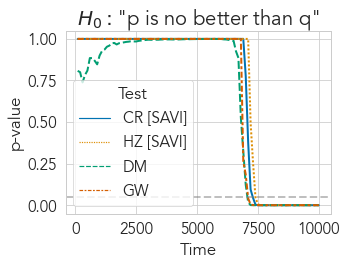

In [19]:
pvalues = pd.concat([safe_p, safe_p_hz, unsafe_p], ignore_index=True)
#pvalues = pvalues.rename(columns={"p-value": "P-value"})

plt.figure(figsize=(5, 4))
ax = sns.lineplot(
    x="Time",
    y="p-value",
    linewidth=2,
    hue="Test",
    style="Test",
    style_order=["CR [SAVI]", "DM", "HZ [SAVI]", "GW"],
    data=pvalues,
)
ax.set_title(
    r"$H_0:$" + "\"p is no better than q\"",
    fontsize="large",
)
ax.axhline(y=0.05, color="gray", alpha=0.5, linewidth=2, linestyle="dashed")
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "pvalue_comparison.pdf"),
            dpi=savefig_dpi)
None

## *Checking DM Assumptions (stationarity)

In particular: covariance stationarity (clearly violated in the above examples).

In [20]:
deltas = cc.cumul_mean(loss_q - loss_p)

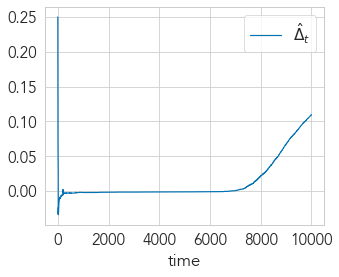

In [21]:
plt.figure(figsize=(5, 4))
sns.lineplot(x=data.time, y=deltas, label=r"$\hat\Delta_t$")
None

In [22]:
# ignore the first few steps
offset = 500

In [23]:
import statsmodels.api as sm

# H_0: white noise vs. H_1: not white noise
sm.stats.acorr_ljungbox(deltas[offset:], lags=1)

,lb_stat,lb_pvalue
1,9492.371155,0.0


In [24]:
import statsmodels.tsa.api as tsa

# H_0: non-stationary vs. H_1: AR(1) stationary
tsa.adfuller(deltas[offset:])

(7.200598693670573,
 1.0,
 38,
 9461,
 {'1%': -3.431041372489004,
  '5%': -2.8618455435967367,
  '10%': -2.5669326357576447},
 -170529.86979810375)